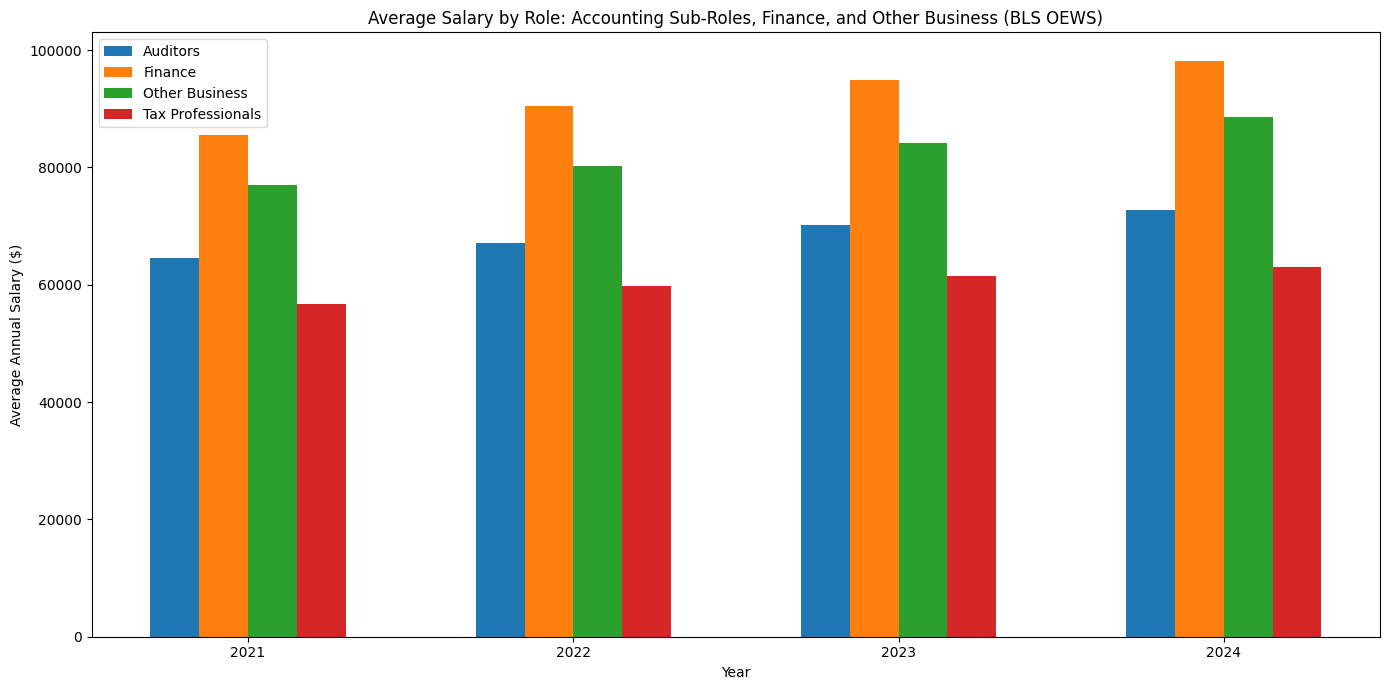

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) HELPER: LOAD + CLEAN ONE FILE ----------

def load_and_clean(path):
    df = pd.read_excel(path)

    # strip spaces from column names
    df.columns = df.columns.str.strip()

    # drop exact duplicate rows
    df = df.drop_duplicates()

    # drop rows missing key identifiers
    if {"OCC_CODE", "OCC_TITLE"}.issubset(df.columns):
        df = df.dropna(subset=["OCC_CODE", "OCC_TITLE"])

    # make sure wage columns are numeric
    for col in ["A_MEAN", "A_MEDIAN"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

# ---------- 2) LOAD + CLEAN EACH YEAR, ADD YEAR COLUMN ----------

df_2021 = load_and_clean("national_M2021_dl.xlsx")
df_2022 = load_and_clean("national_M2022_dl.xlsx")
df_2023 = load_and_clean("national_M2023_dl.xlsx")
df_2024 = load_and_clean("national_M2024_dl.xlsx")

df_2021["year"] = 2021
df_2022["year"] = 2022
df_2023["year"] = 2023
df_2024["year"] = 2024

# ---------- 3) COMBINE ALL YEARS ----------

df_all = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)
df_all = df_all.drop_duplicates()

# ---------- 4) CLASSIFY JOBS INTO GROUPS (ACCOUNTING SUB-ROLES + FINANCE + OTHER) ----------

titles = df_all["OCC_TITLE"]

# Auditors (external + internal)
auditor_mask = titles.str.contains("Auditor|Auditing", case=False, na=False)

# Tax professionals
tax_mask = titles.str.contains("Tax Examiner|Tax Preparer|Tax Collector|Tax Specialist",
                               case=False, na=False)

# Accountants (NOT auditors or tax)
accountant_mask = titles.str.contains("Accountant|Accounting", case=False, na=False) \
                   & ~auditor_mask & ~tax_mask

# Finance jobs
finance_mask = titles.str.contains("Financial|Credit|Budget|Loan Officer",
                                   case=False, na=False)

# Other business: SOC major group 13-**** (business & financial operations)
business_mask = df_all["OCC_CODE"].str.startswith("13")

df_all["Job_Group"] = None
df_all.loc[business_mask, "Job_Group"] = "Other Business"
df_all.loc[finance_mask, "Job_Group"] = "Finance"
df_all.loc[accountant_mask, "Job_Group"] = "Accountants"
df_all.loc[auditor_mask, "Job_Group"] = "Auditors"
df_all.loc[tax_mask, "Job_Group"] = "Tax Professionals"

# keep only rows we classified and that have a mean salary
df_groups = df_all.dropna(subset=["Job_Group", "A_MEAN"])

# ---------- 5) BUILD SALARY TREND TABLE ----------

salary_trend = (
    df_groups.groupby(["year", "Job_Group"])["A_MEAN"]
    .mean()
    .reset_index()
)

# pivot to: index = year, columns = Job_Group, values = avg salary
pivot = salary_trend.pivot(index="year", columns="Job_Group", values="A_MEAN")

# ---------- 6) GROUPED BAR CHART ----------

years = pivot.index.to_list()
groups = pivot.columns.to_list()  # e.g. ['Accountants', 'Auditors', 'Tax Professionals', 'Finance', 'Other Business']

bar_width = 0.15
x = np.arange(len(years))

plt.figure(figsize=(14, 7))

for i, group in enumerate(groups):
    plt.bar(x + i * bar_width, pivot[group], width=bar_width, label=group)

# center tick labels under the group of bars
plt.xticks(x + bar_width * (len(groups) - 1) / 2, years)

plt.xlabel("Year")
plt.ylabel("Average Annual Salary ($)")
plt.title("Average Salary by Role: Accounting Sub-Roles, Finance, and Other Business (BLS OEWS)")
plt.legend()
plt.tight_layout()
plt.show()


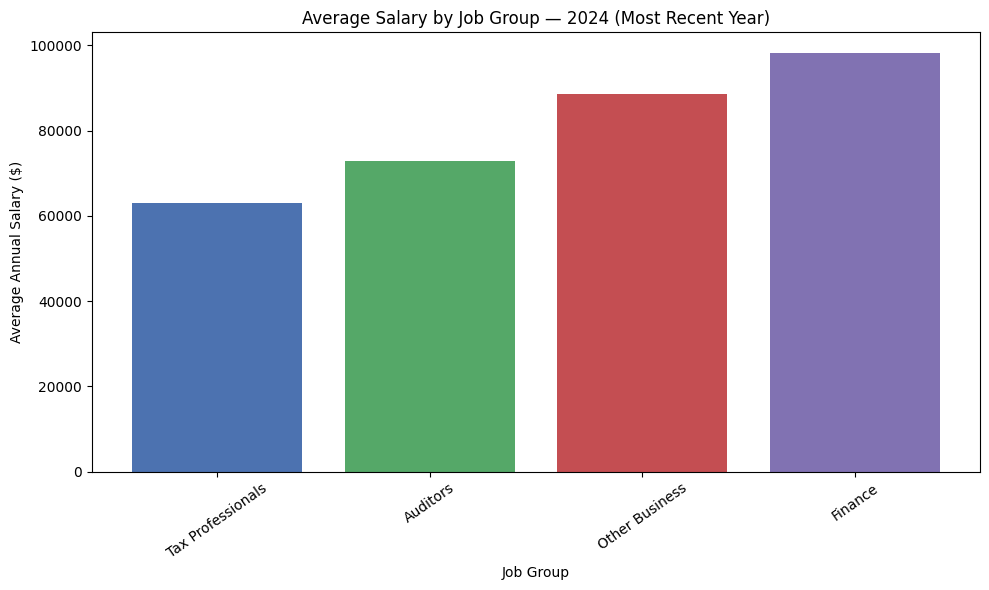

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) HELPER: LOAD + CLEAN ONE FILE ----------

def load_and_clean(path):
    df = pd.read_excel(path)

    # strip spaces from column names
    df.columns = df.columns.str.strip()

    # drop exact duplicate rows
    df = df.drop_duplicates()

    # drop rows missing key identifiers
    if {"OCC_CODE", "OCC_TITLE"}.issubset(df.columns):
        df = df.dropna(subset=["OCC_CODE", "OCC_TITLE"])

    # make sure wage columns are numeric
    for col in ["A_MEAN", "A_MEDIAN"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

# ---------- 2) LOAD + CLEAN EACH YEAR, ADD YEAR COLUMN ----------

df_2021 = load_and_clean("national_M2021_dl.xlsx")
df_2022 = load_and_clean("national_M2022_dl.xlsx")
df_2023 = load_and_clean("national_M2023_dl.xlsx")
df_2024 = load_and_clean("national_M2024_dl.xlsx")

df_2021["year"] = 2021
df_2022["year"] = 2022
df_2023["year"] = 2023
df_2024["year"] = 2024

# ---------- 3) COMBINE ALL YEARS ----------

df_all = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)
df_all = df_all.drop_duplicates()

# ---------- 4) CLASSIFY JOBS INTO GROUPS (ACCOUNTING SUB-ROLES + FINANCE + OTHER) ----------

titles = df_all["OCC_TITLE"]

auditor_mask = titles.str.contains("Auditor|Auditing", case=False, na=False)
tax_mask = titles.str.contains("Tax Examiner|Tax Preparer|Tax Collector|Tax Specialist",
                               case=False, na=False)
accountant_mask = titles.str.contains("Accountant|Accounting", case=False, na=False) \
                   & ~auditor_mask & ~tax_mask
finance_mask = titles.str.contains("Financial|Credit|Budget|Loan Officer",
                                   case=False, na=False)
business_mask = df_all["OCC_CODE"].str.startswith("13")

df_all["Job_Group"] = None
df_all.loc[business_mask, "Job_Group"] = "Other Business"
df_all.loc[finance_mask, "Job_Group"] = "Finance"
df_all.loc[accountant_mask, "Job_Group"] = "Accountants"
df_all.loc[auditor_mask, "Job_Group"] = "Auditors"
df_all.loc[tax_mask, "Job_Group"] = "Tax Professionals"

df_groups = df_all.dropna(subset=["Job_Group", "A_MEAN"])

# ---------- 5) FILTER TO MOST RECENT YEAR (2024) ONLY ----------

df_2024_only = df_groups[df_groups["year"] == 2024]

# compute average salary by job group for 2024
avg_2024 = df_2024_only.groupby("Job_Group")["A_MEAN"].mean().sort_values()

# ---------- 6) BAR CHART FOR 2024 ONLY ----------

plt.figure(figsize=(10, 6))
plt.bar(avg_2024.index, avg_2024.values, color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"])

plt.xlabel("Job Group")
plt.ylabel("Average Annual Salary ($)")
plt.title("Average Salary by Job Group — 2024 (Most Recent Year)")
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()
